In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import plotly.graph_objects as go

In [67]:
trs = pd.read_excel("ghmc_trs.xlsx")


In [68]:
bjp = pd.read_excel("ghmc_bjp.xlsx")


In [69]:
aimim = pd.read_excel("ghmc_AIMIM.xlsx")


In [70]:

bjp = bjp.drop(columns = ['From-User-Id','To-User','To-User-Id','Geo-Location-Latitude','Geo-Location-Longitude','Id'])

In [71]:
aimim = aimim.drop(columns = ['From-User-Id','To-User','To-User-Id','Geo-Location-Latitude','Geo-Location-Longitude','Id'])


In [72]:
trs = trs.drop(columns = ['From-User-Id','To-User','To-User-Id','Geo-Location-Latitude','Geo-Location-Longitude','Id'])

In [73]:
bjp.loc[:,'candidate'] = 'bjp'
trs.loc[:,'candidate'] = 'trs'
aimim.loc[:,'candidate'] = 'aimim'


In [74]:
Data_Mixed = pd.concat([bjp,trs,aimim])
Data_Mixed.sort_values(by='Created-At')
Data_Mixed.head()

,Created-At,From-User,Language,Source,Text,Retweet-Count,candidate
0,2020-12-04 10:36:31,Konda Vishweshwar Reddy,en,"<a href=""http://twitter.com/download/android"" ...",Postal ballots reflect the opinion of the empl...,120,bjp
1,2020-12-04 10:27:33,ANI,en,"<a href=""https://mobile.twitter.com"" rel=""nofo...",The transformation has started in the state of...,54,bjp
2,2020-12-04 11:44:12,OpIndia.com,en,"<a href=""https://about.twitter.com/products/tw...",Early trends show BJP leading in 88 seats in H...,58,bjp
3,2020-12-04 12:31:42,Kali Yuga ????????????,en,"<a href=""http://twitter.com/download/android"" ...",@SheetalPronamo @ashishjaggi_1 The agression w...,0,bjp
4,2020-12-04 12:31:38,Priyarag Verma,en,"<a href=""http://twitter.com/download/android"" ...",GHMC Election Results 2020 trends from ballot ...,0,bjp


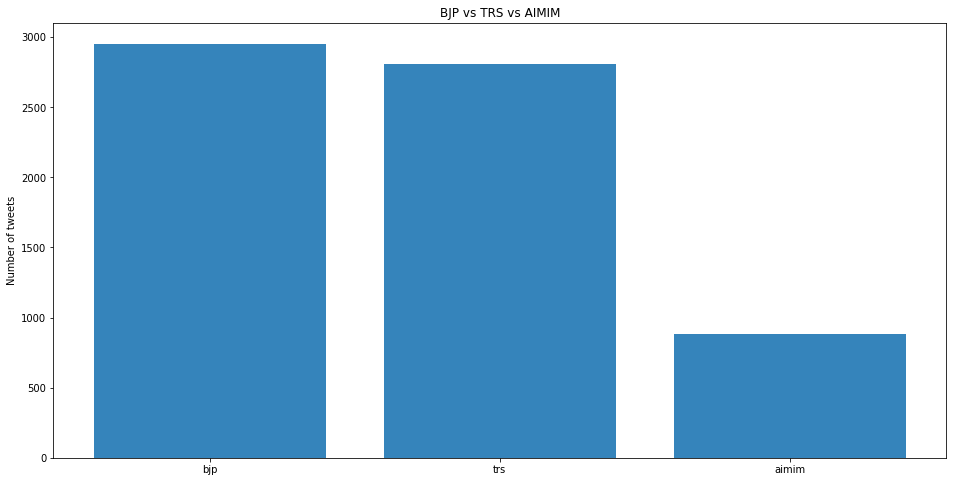

In [76]:
Bjp_tweets = Data_Mixed.query('(candidate == "bjp")').Text.sort_values(ascending=False).count()
Trs_tweets = Data_Mixed.query('(candidate == "trs")').Text.sort_values(ascending=False).count()
Aimim_tweets = Data_Mixed.query('(candidate == "aimim")').Text.sort_values(ascending=False).count()

objects = ('bjp','trs','aimim')
y_pos = np.arange(len(objects))
performance = [Bjp_tweets,Trs_tweets,Aimim_tweets]

fig = plt.figure(figsize=(16,8))
plt.bar(y_pos, performance, align='center', alpha=0.9)
plt.xticks(y_pos, objects)
plt.ylabel('Number of tweets')
plt.title('BJP vs TRS vs AIMIM')

fig.savefig('BJP vs TRS vs AIMIM.png')

plt.show()

In [77]:
import re 

def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    return text

In [78]:
# create fuction to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score== 0.0:
        return 'neutral'
    else:
        return 'positive'

In [79]:
BJP_Tweets = Data_Mixed.query('(candidate == "bjp")').sort_values('Retweet-Count',ascending = False).drop_duplicates(['From-User'])[['Text']]

BJP_Tweets.reset_index(inplace = True, drop = True)

BJP_Tweets['ClearTweet'] = BJP_Tweets['Text'].apply(clean)

BJP_Tweets['subjectivity']= BJP_Tweets['ClearTweet'].apply(getSubjectivity)
BJP_Tweets['polarity']    = BJP_Tweets['ClearTweet'].apply(getPolarity)
BJP_Tweets['analysis']    = BJP_Tweets['polarity'].apply(getAnalysis)
BJP_Tweets.head()


BJP_Tweets.head()

,Text,ClearTweet,subjectivity,polarity,analysis
0,Dastardly attack on @BJP4Telangana Pres. @band...,dastardly attack on pres _bjp by trs mim go...,1.000000,0.000000,neutral
1,A local election with national implications. A...,a local election with national implications a...,0.000000,0.000000,neutral
2,#Thread : BJP and the need for the saffron par...,thread bjp and the need for the saffron part...,0.450000,0.650000,positive
3,BJP HYDERABAD GHMC PROMISES\n\n1. Free Electri...,bjp hyderabad ghmc free electricity till ...,0.683333,0.333333,positive
4,LIVE: My statement from Police Station on pre-...,live my statement from police station on pre ...,0.750000,0.068182,positive


In [80]:
BJP_Tweets.polarity = BJP_Tweets.polarity.apply(lambda x: getAnalysis(x))

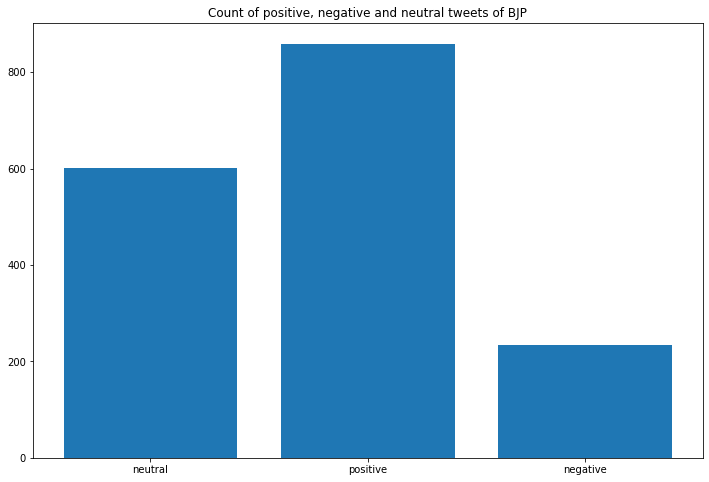

In [81]:
from collections import Counter

target_cnt = Counter(BJP_Tweets.polarity)

fig = plt.figure(figsize=(12,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Count of positive, negative and neutral tweets of BJP")

fig.savefig("BJPcount.png")

In [82]:
general  = BJP_Tweets.groupby('analysis').analysis.count()
neutral  = BJP_Tweets[BJP_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = BJP_Tweets[BJP_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = BJP_Tweets[BJP_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='Sentiment analysis tweets BJP')
fig.show()

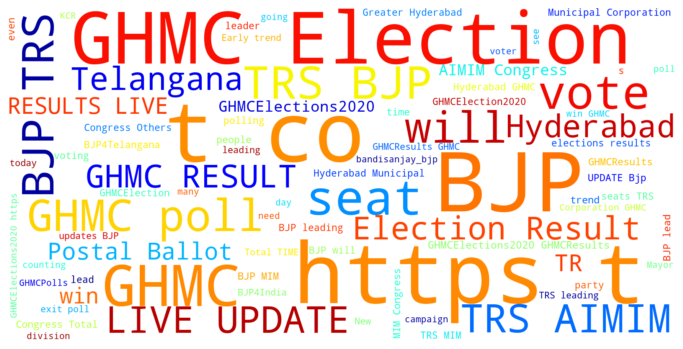

In [83]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    fig = plt.figure(figsize=(12, 8))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")
    fig.savefig("BJPwordcloud")
word_cloud(bjp['Text'][0:1000])

In [84]:
TRS_Tweets = Data_Mixed.query('(candidate == "trs")').sort_values('Retweet-Count',ascending = False).drop_duplicates(['From-User'])[['Text']]

TRS_Tweets.reset_index(inplace = True, drop = True)

TRS_Tweets['ClearTweet'] = TRS_Tweets['Text'].apply(clean)

TRS_Tweets['subjectivity']= TRS_Tweets['ClearTweet'].apply(getSubjectivity)
TRS_Tweets['polarity']    = TRS_Tweets['ClearTweet'].apply(getPolarity)
TRS_Tweets['analysis']    = TRS_Tweets['polarity'].apply(getAnalysis)
TRS_Tweets.head()


TRS_Tweets.head()

,Text,ClearTweet,subjectivity,polarity,analysis
0,Massive distribution of money in different par...,massive distribution of money in different par...,0.866667,-0.266667,negative
1,HM Amit Shah is holding a roadshow for the cru...,hm amit shah is holding a roadshow for the cru...,1.000000,0.000000,neutral
2,Home Minister @AmitShah will be in Secunderaba...,home minister will be in secunderabad holding...,1.000000,-0.250000,negative
3,The TRS MIM-led GHMC is interested only in new...,the trs mim led ghmc is interested only in new...,0.531602,0.183766,positive
4,A local election with national implications. A...,a local election with national implications a...,0.000000,0.000000,neutral


In [85]:
TRS_Tweets.polarity = TRS_Tweets.polarity.apply(lambda x: getAnalysis(x))

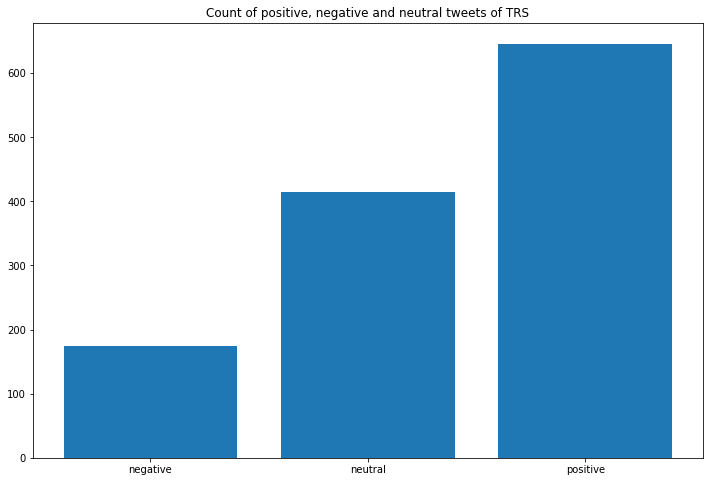

In [86]:
from collections import Counter

target_cnt = Counter(TRS_Tweets.polarity)

fig = plt.figure(figsize=(12,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Count of positive, negative and neutral tweets of TRS")
fig.savefig("TRScount.png")

In [87]:
general  = TRS_Tweets.groupby('analysis').analysis.count()
neutral  = TRS_Tweets[TRS_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = TRS_Tweets[TRS_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = TRS_Tweets[TRS_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='Sentiment analysis of tweets of TRS')
fig.show()

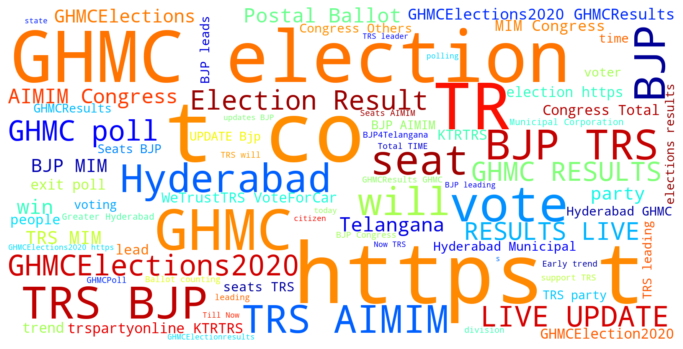

In [88]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    fig = plt.figure(figsize=(12,8))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")
    fig.savefig("TRSwordcloud.png")
word_cloud(trs['Text'][0:1000])

In [89]:
AIMIM_Tweets = Data_Mixed.query('(candidate == "aimim")').sort_values('Retweet-Count',ascending = False).drop_duplicates(['From-User'])[['Text']]

AIMIM_Tweets.reset_index(inplace = True, drop = True)

AIMIM_Tweets['ClearTweet'] = AIMIM_Tweets['Text'].apply(clean)

AIMIM_Tweets['subjectivity']= AIMIM_Tweets['ClearTweet'].apply(getSubjectivity)
AIMIM_Tweets['polarity']    = AIMIM_Tweets['ClearTweet'].apply(getPolarity)
AIMIM_Tweets['analysis']    = AIMIM_Tweets['polarity'].apply(getAnalysis)
AIMIM_Tweets.head()


AIMIM_Tweets.head()

,Text,ClearTweet,subjectivity,polarity,analysis
0,HM Amit Shah is holding a roadshow for the cru...,hm amit shah is holding a roadshow for the cru...,1.000000,0.000000,neutral
1,AIMIM President Barrister @asadowaisi in conve...,aimim president barrister in conversation wit...,0.000000,0.000000,neutral
2,As polling day approaches it’s clearly a battl...,as polling day approaches it s clearly a battl...,0.670833,0.187500,positive
3,A BJP leader y'day said BJP will do a surgical...,a bjp leader y day said bjp will do a surgical...,0.300000,0.178788,positive
4,GHMC polls: Raja Singh offers Asaduddin Owaisi...,ghmc polls raja singh offers asaduddin owaisi...,0.375000,0.275000,positive


In [90]:
AIMIM_Tweets.polarity = AIMIM_Tweets.polarity.apply(lambda x: getAnalysis(x))

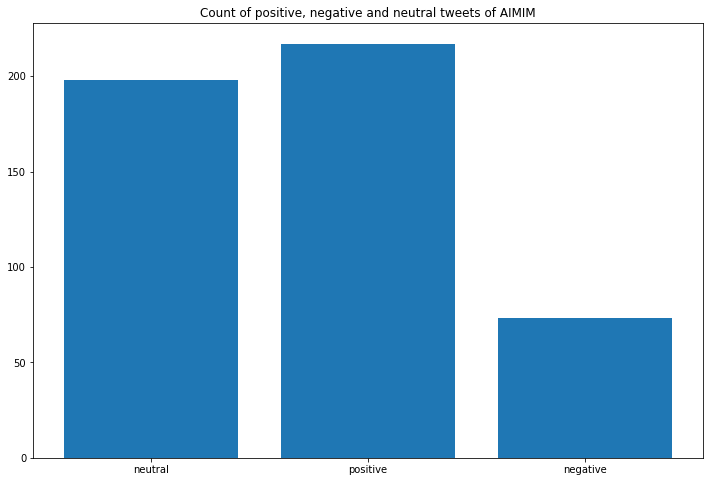

In [91]:
from collections import Counter

target_cnt = Counter(AIMIM_Tweets.polarity)

fig = plt.figure(figsize=(12,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Count of positive, negative and neutral tweets of AIMIM")
fig.savefig("AIMIMcount.png")

In [92]:
general  = AIMIM_Tweets.groupby('analysis').analysis.count()
neutral  = AIMIM_Tweets[TRS_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = AIMIM_Tweets[TRS_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = AIMIM_Tweets[TRS_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='Sentiment analysis tweets AIMIM')
fig.show()

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\prana\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



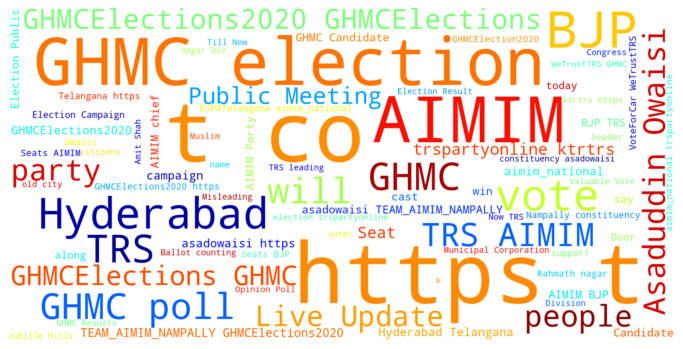

In [93]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    fig = plt.figure(figsize=(12,8))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")
    fig.savefig("AIMIMwordcloud.png")
word_cloud(aimim['Text'][0:1000])